### Setup

In [1]:
# databases
import psycopg2
import sqlparse

# external core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# utility
import getpass
from tqdm.notebook import tqdm

### PostgreSQL Login

In [130]:
# connect to postgres
pg_password = getpass.getpass("Enter Postgres Password: ")
pg = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password=pg_password,
    host="localhost",
    port="5433"
)

cur = pg.cursor()

### Analysis

##### Identify all tables

In [3]:
query = "SELECT tablename FROM pg_catalog.pg_tables WHERE schemaname='public';"
cur.execute(query)
table_names = cur.fetchall()

for table_name in table_names:
    print(table_name[0])

accidents
accident_info
accidents_on_road
roads
reports
reports_on_road


##### Visualize tables

In [19]:
def previewTable(tableName, endIdx, separator="\t   "):
    table_name = tableName
    table_query = f"SELECT * FROM {table_name};"

    cur.execute(table_query)
    column_names = [desc[0] for desc in cur.description]
    print(", ".join(column_names))
    rows = cur.fetchall()
    start = 0
    end = endIdx

    for r in rows:
        values = [str(value) for value in r]
        print(separator.join(values))
        start += 1
        if not (start-end):
            break

In [41]:
previewTable("accidents", 5, separator=",\t  ")

report_id, date_time, violation_section, violation_type, injured, killed, hit_run_lvl
171111,	  2015-01-14 20:00:00,	  MISC-HAZ,	  VC,	  0,	  0,	  MISDEMEANOR
192016,	  2015-03-19 12:00:00,	  MISC-HAZ,	  VC,	  0,	  0,	  MISDEMEANOR
190012,	  2015-03-24 03:05:00,	  22107,	  VC,	  2,	  0,	  
191866,	  2015-03-27 23:56:00,	  22107,	  VC,	  1,	  0,	  
185207,	  2015-07-06 11:45:00,	  20002(A),	  VC,	  0,	  0,	  MISDEMEANOR


In [27]:
previewTable("accident_info", 5, separator=", ")

report_id, person_role, veh_make, veh_model
171111, PARKED VEHICLE OCCUPANT, TOYOTA, RAV4
192016, PARKED VEHICLE OCCUPANT, FORD, 
190012, DRIVER, NISSAN, ALTIMA
191866, DRIVER, FORD, F150
185207, DRIVER, FORD, MUSTANG


In [22]:
previewTable("accidents_on_road", 2, separator=", ")

report_id, objectid
171111, 8708
192016, 2649


In [42]:
previewTable("roads", 5, separator=",\t  ")

objectid, roadsegid, roadid, road_name, speed, oneway, firedriv
17,	  2014,	  2225,	  08TH AV,	  20,	  T,	  Y
18,	  2027,	  2225,	  08TH AV,	  20,	  T,	  Y
19,	  2029,	  2225,	  08TH AV,	  20,	  T,	  Y
20,	  2031,	  2225,	  08TH AV,	  20,	  T,	  Y
21,	  2034,	  2225,	  08TH AV,	  20,	  B,	  Y


In [33]:
previewTable("reports", 5, separator=", ")

service_request_id, date_requested, case_age_days, service_name, service_name_detail, status, street_address, council_district, case_origin
100763, 2016-08-20 14:46:00, 2470, Street Sweeping, , In Process, 5135 University Avenue San Diego CA 92105 United States, 9, Web
100777, 2016-08-20 15:48:00, 2470, Sidewalk Repair Issue, SIDEWALK MINOR REHAB CONTRACT, In Process, 4300-4324 37th St San Diego CA 92105 USA, 9, Web
100985, 2016-08-22 10:04:00, 2468, Stormwater, DRAIN HEADWALL, In Process, 6175 NANCY RIDGE DR 92121, 6, Phone
101169, 2016-08-23 08:30:00, 2467, Pavement Maintenance, DAMAGED CURB, In Process, 2950-52 National Avenue San Diego, 8, Web
101707, 2016-08-25 15:01:00, 2465, Pavement Maintenance, DAMAGED CURB, In Process, 2220 Ocean View Boulevard San Diego CA United States, 8, Web


In [44]:
previewTable("reports_on_road", 5, separator=",\t\t   ")

service_request_id, objectid
100777,		   69508
100985,		   20182
101798,		   93638
101799,		   93638
101870,		   22009


##### Analyze Data

Question: What is the total number of accidents and the number of accidents with injuries or fatalities.

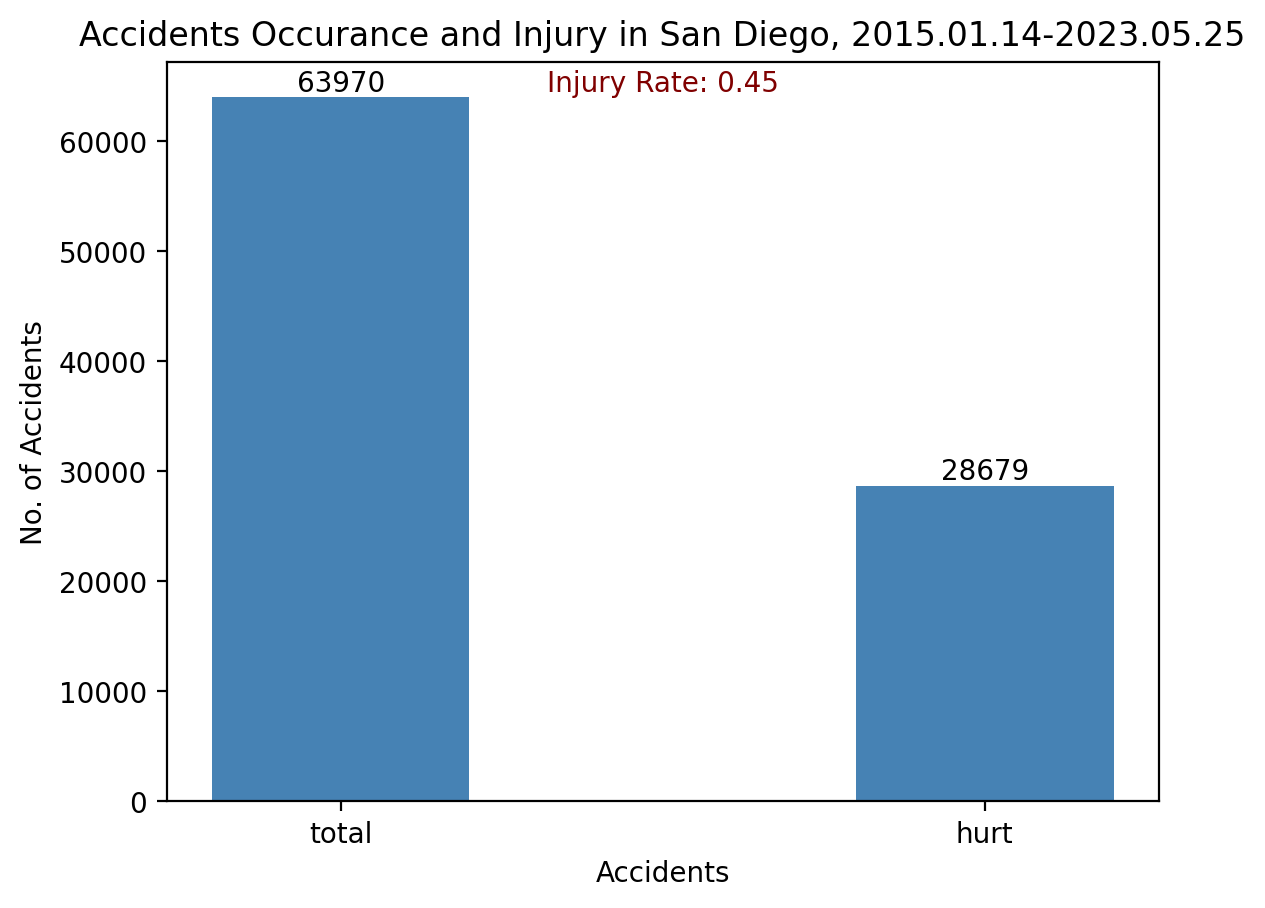

In [119]:
query = \
    """
    SELECT
        COUNT(*),
        SUM(CASE WHEN injured > 0 OR killed > 0 THEN 1 ELSE 0 END)
    FROM accidents;
    """

cur.execute(query)
result = cur.fetchall()

time_qeury = "SELECT MIN(date_time), MAX(date_time) FROM accidents;"
cur.execute(time_qeury)
time_range = cur.fetchall()[0]
start = time_range[0].strftime("%Y.%m.%d")
end = time_range[1].strftime("%Y.%m.%d")
xlocs, xlabs = plt.xticks()

plt.bar(["total", "hurt"], result[0], color ='steelblue',
        width = 0.4)

for i, v in enumerate(result[0]):
    plt.text(i, v, str(v), ha='center', va='bottom', color='black')

injure_rate = result[0][1] / result[0][0]
plt.text(0.5, max(result[0]), f"Injury Rate: {injure_rate:.2f}",
        color='maroon', ha='center', va='bottom')

plt.xlabel("Accidents")
plt.ylabel("No. of Accidents")
plt.title(f"Accidents Occurance and Injury in San Diego, {start}-{end}")
plt.show()

Question: What is the percentage of accidents where hit-and-run was involved.

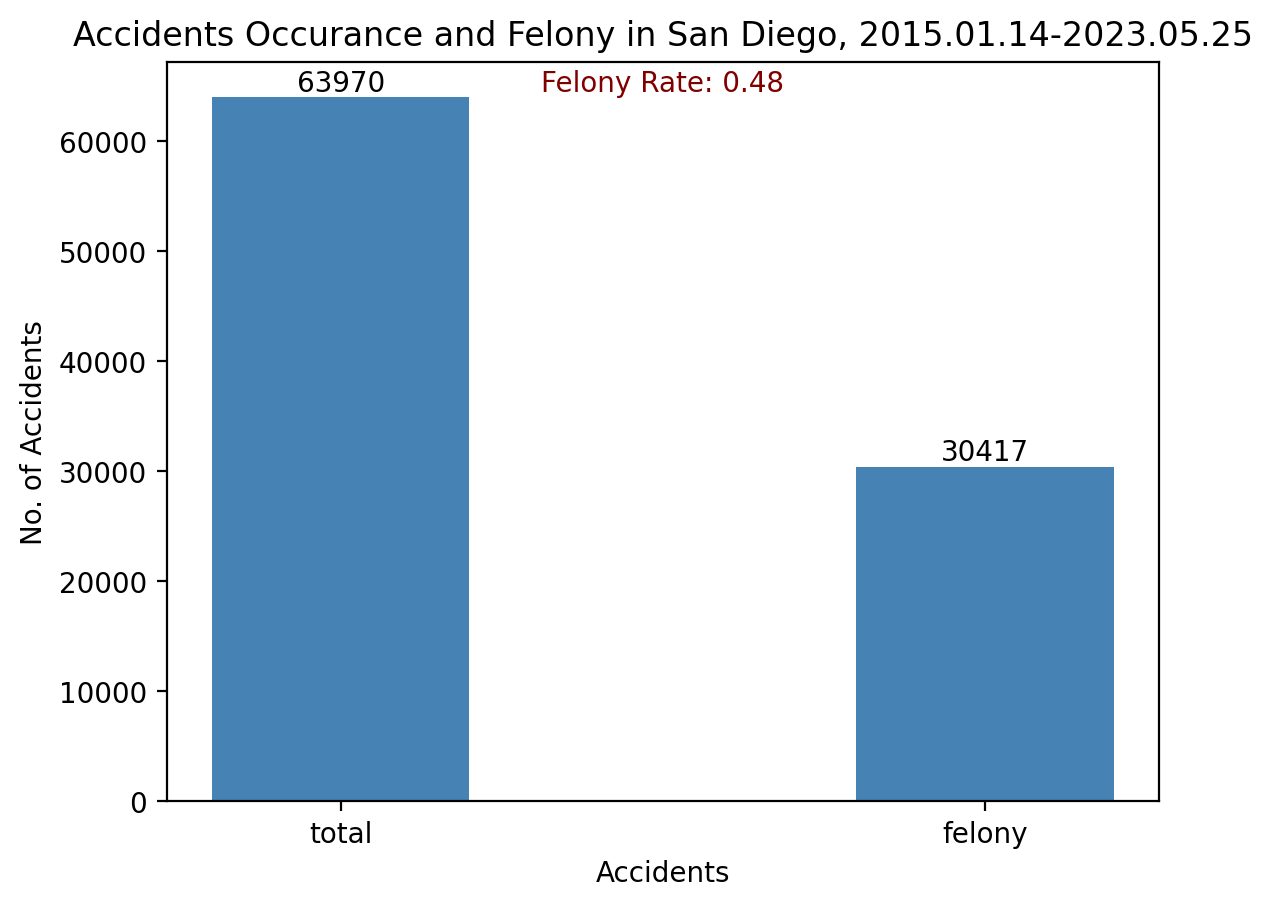

[(63970, 30417)]


In [120]:
query = \
    """
    SELECT
        COUNT(*) AS total_accidents,
        COUNT(*) FILTER (WHERE hit_run_lvl = 'MISDEMEANOR' OR hit_run_lvl = 'FELONY')
    FROM accidents;
    """

cur.execute(query)
result = cur.fetchall()

plt.bar(["total", "felony"], result[0], color ='steelblue',
        width = 0.4)

for i, v in enumerate(result[0]):
    plt.text(i, v, str(v), ha='center', va='bottom', color='black')

felony_rate = result[0][1] / result[0][0]
plt.text(0.5, max(result[0]), f"Felony Rate: {felony_rate:.2f}",
        color='maroon', ha='center', va='bottom')

plt.xlabel("Accidents")
plt.ylabel("No. of Accidents")
plt.title(f"Accidents Occurance and Felony in San Diego, {start}-{end}")
plt.show()

print(result)

Question: Which road has the most felony and injury.

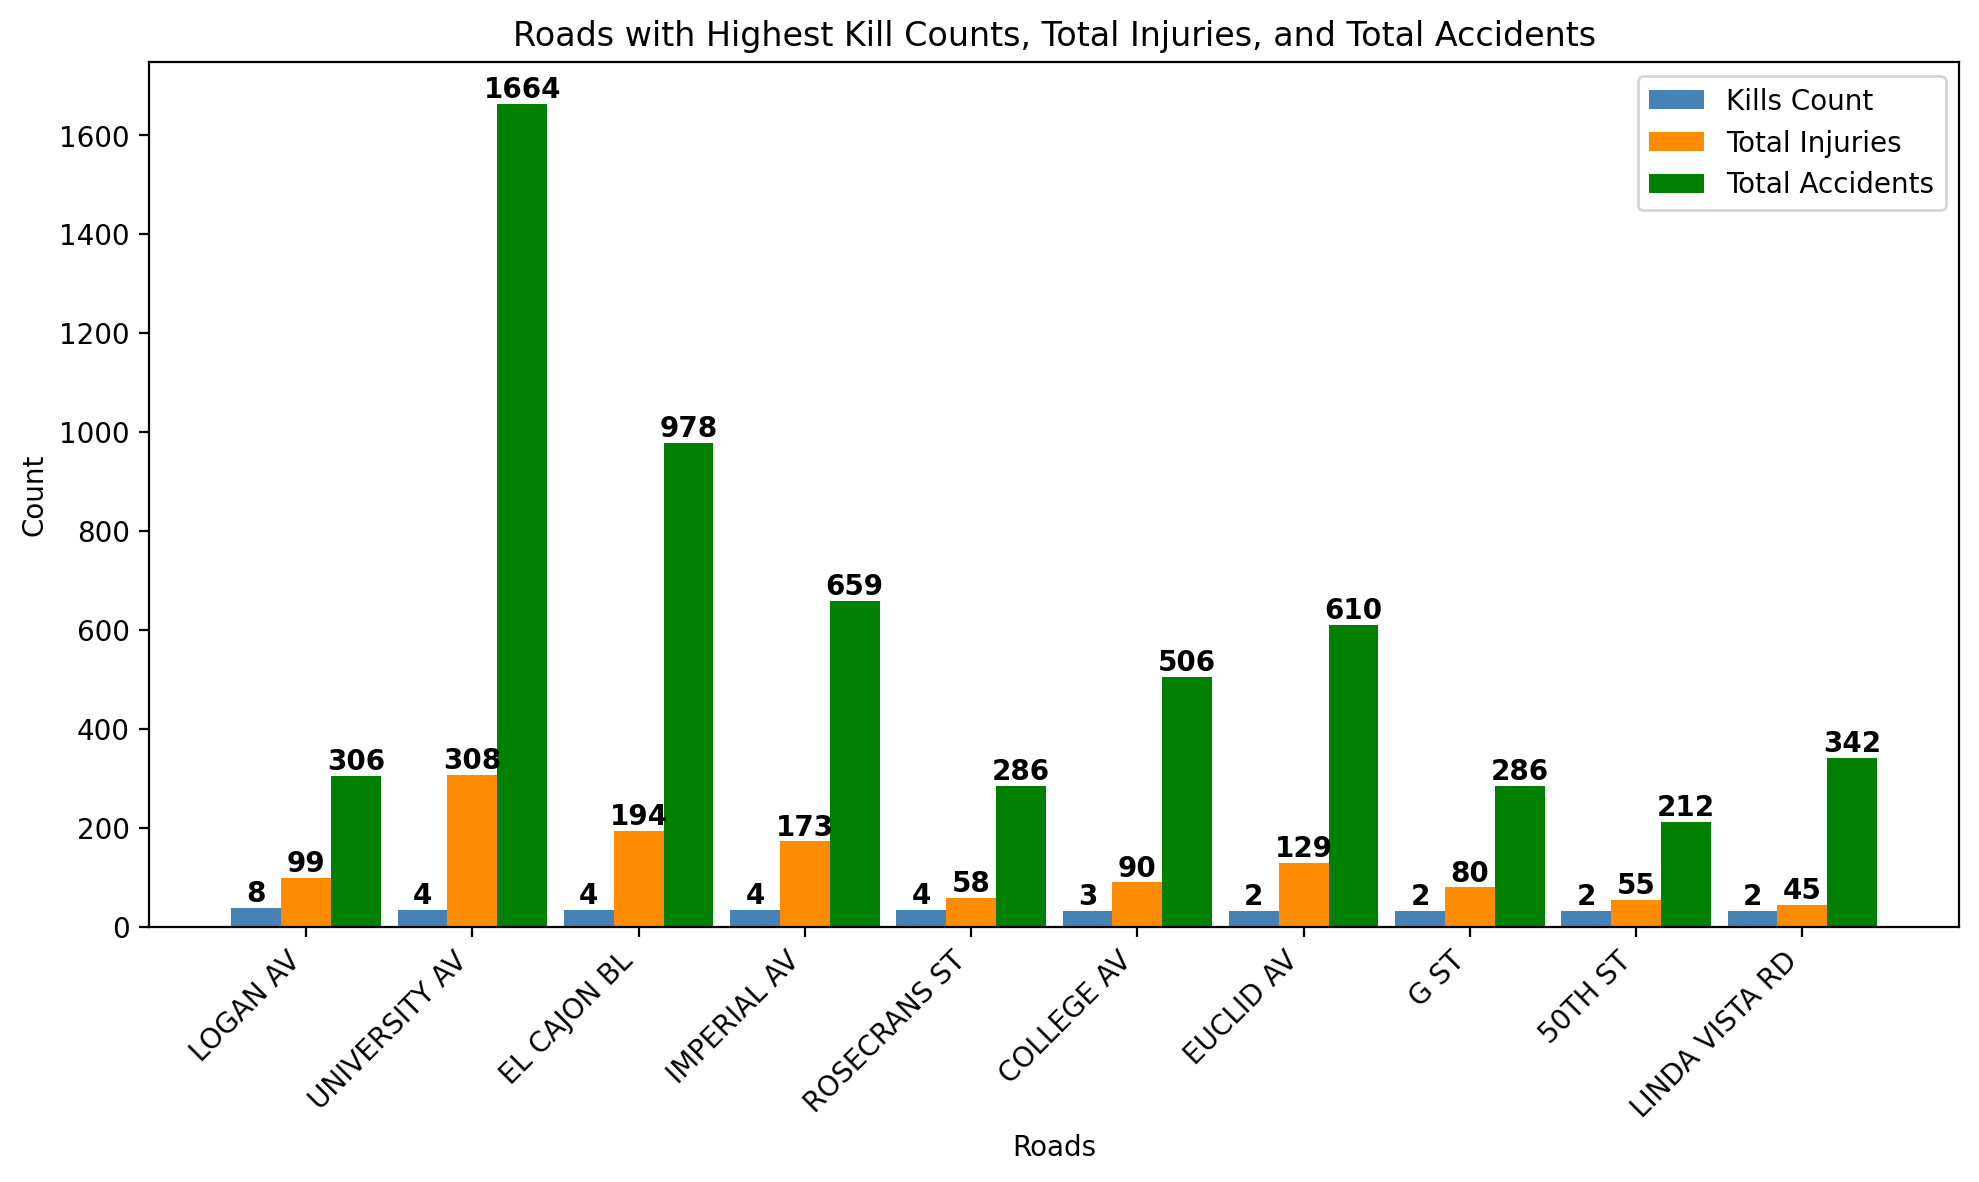

In [141]:
query = \
    """
    SELECT
        r.road_name,
        SUM(a.killed) AS total_killed,
        SUM(a.injured) AS total_injuries,
        COUNT(*) AS felony_count
    FROM
        accidents AS a
    JOIN
        accidents_on_road AS ar ON a.report_id = ar.report_id
    JOIN
        roads AS r ON ar.objectid = r.objectid
    WHERE
        a.hit_run_lvl = 'FELONY' OR a.hit_run_lvl = 'MISDEMEANOR'
    GROUP BY
        r.road_name
    ORDER BY
        total_killed DESC, total_injuries DESC, felony_count DESC
    LIMIT 10;
    """

cur.execute(query)
result = cur.fetchall()

roads = [tup[0] for tup in result]
kill_counts = [tup[1]+30 for tup in result]
injury_counts = [tup[2] for tup in result]
accident_counts = [tup[3] for tup in result]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3

index = np.arange(len(roads))
plt.bar(index, kill_counts, width=bar_width, color='steelblue', label='Kills Count')
plt.bar(index + bar_width, injury_counts, width=bar_width, color='darkorange', label='Total Injuries')
plt.bar(index + 2*bar_width, accident_counts, width=bar_width, color='green', label='Total Accidents')

plt.xlabel('Roads')
plt.ylabel('Count')
plt.xticks(index + bar_width, roads, rotation=45, ha='right')

plt.legend()

# Add labels to the bars
for i, v in enumerate(kill_counts):
    # v -= 30
    plt.text(i, v, str(v-30), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(injury_counts):
    plt.text(i + bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(accident_counts):
    plt.text(i + 2*bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

# Add a title
plt.title('Roads with Highest Kill Counts, Total Injuries, and Total Accidents')

# Show the plot
plt.tight_layout()
plt.show()

Question: What is the most common violation types in accidents.

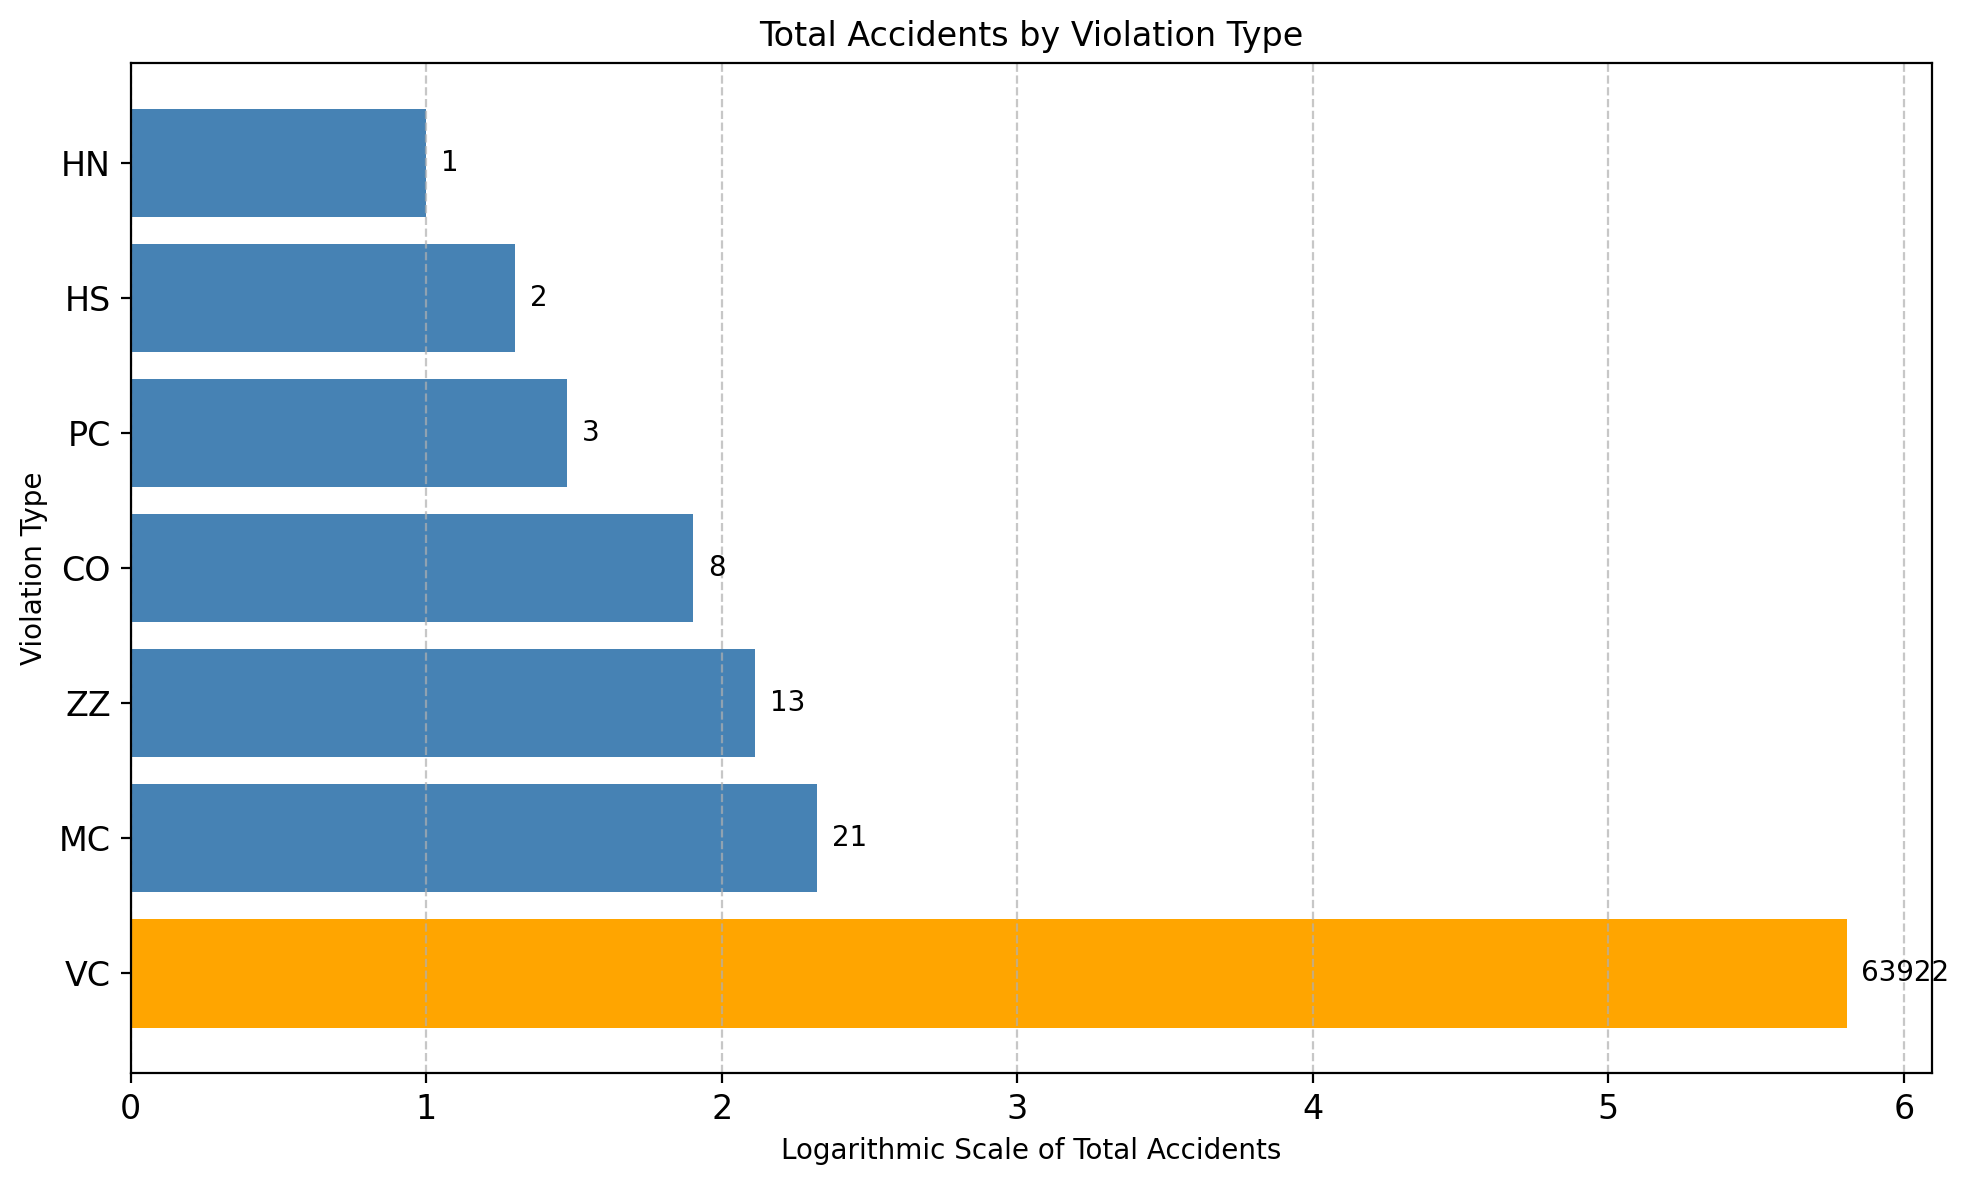

In [105]:
query = \
    """
    SELECT
        violation_type,
        COUNT(*) AS total_accidents
    FROM accidents
    GROUP BY violation_type
    ORDER BY total_accidents DESC;
    """

cur.execute(query)
result = cur.fetchall()

violation_types = [row[0] for row in result]
total_accidents = [row[1] for row in result]

normalized_accidents = np.log10(total_accidents)+1

fig, ax = plt.subplots(figsize=(10, 6))
bar_colors = ['steelblue' for _ in violation_types]
ax.barh(violation_types, normalized_accidents, color=bar_colors)

max_index = np.argmax(normalized_accidents)
ax.patches[max_index].set_facecolor('orange')

for i, v in enumerate(normalized_accidents):
    ax.text(v + 0.05, i, f"{total_accidents[i]}", color='black', va='center')

plt.title("Total Accidents by Violation Type")
plt.xlabel("Logarithmic Scale of Total Accidents")
plt.ylabel("Violation Type")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Question: what is the top 5 roads with the highest number of accidents.

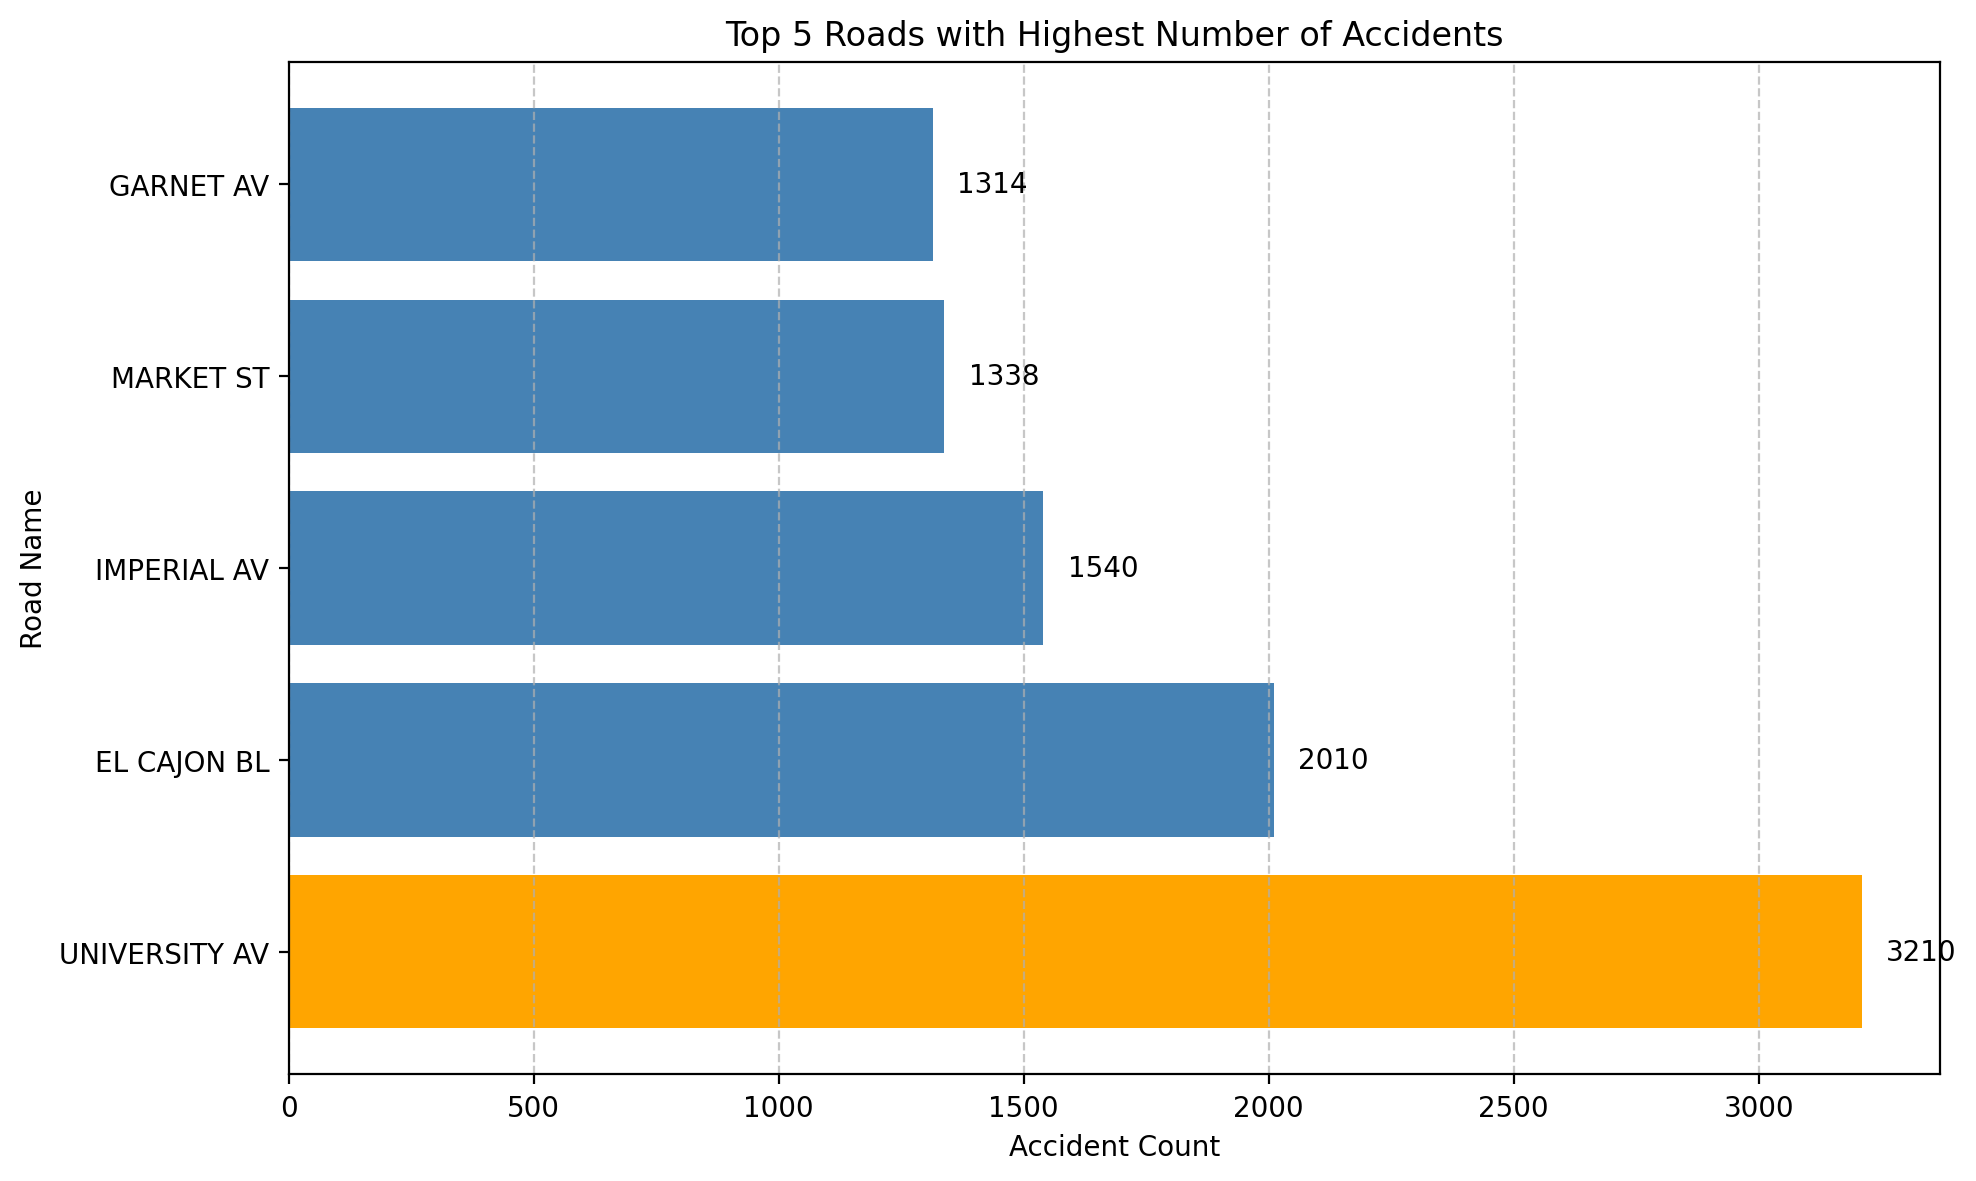

In [104]:
query = \
    """
    SELECT
        r.road_name,
        COUNT(*) AS total_accidents
    FROM accidents_on_road a
    JOIN roads r ON a.objectid = r.objectid
    GROUP BY r.road_name
    ORDER BY total_accidents DESC
    LIMIT 5;
    """

cur.execute(query)
result = cur.fetchall()

road_names = [road[0] for road in result]
accident_counts = [road[1] for road in result]

fig, ax = plt.subplots(figsize=(10, 6))
bar_colors = ['steelblue' for _ in range(len(road_names))]
ax.barh(road_names, accident_counts, color=bar_colors)

max_index = accident_counts.index(max(accident_counts))
ax.patches[max_index].set_facecolor('orange')

for i, v in enumerate(accident_counts):
    ax.text(v + 50, i, str(v), ha='left', va='center', fontsize=10)

plt.title("Top 5 Roads with Highest Number of Accidents")
plt.xlabel("Accident Count")
plt.ylabel("Road Name")

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Question: What is the top 10 most common vehicle makes involved in accidents.

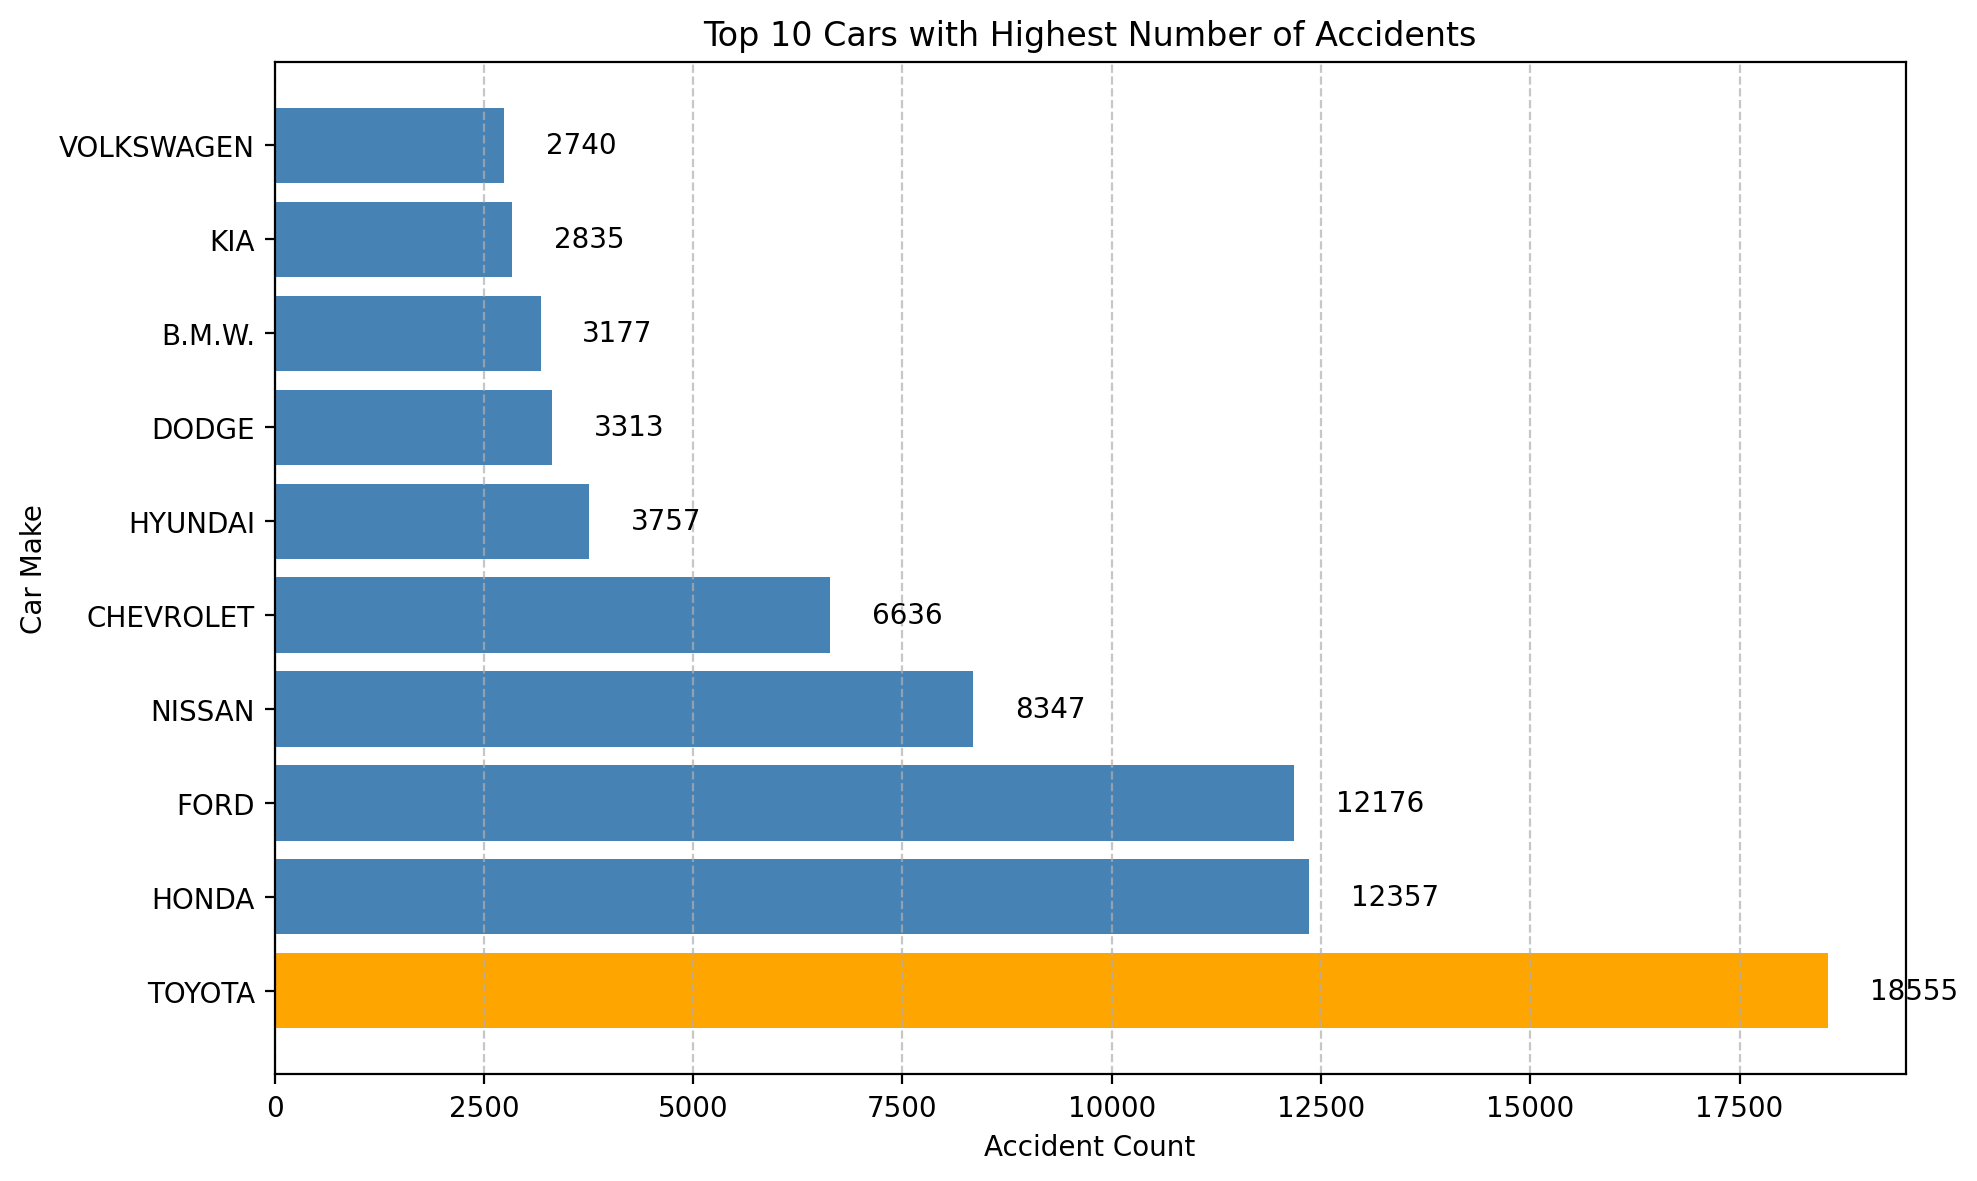

In [87]:
query = \
    """
    SELECT
        veh_make,
        COUNT(*) AS total_accidents
    FROM accident_info
    WHERE veh_make <> ''
    GROUP BY veh_make
    ORDER BY total_accidents DESC
    LIMIT 10
    """

cur.execute(query)
result = cur.fetchall()

car_names = [car[0] for car in result]
accident_counts = [car[1] for car in result]

fig, ax = plt.subplots(figsize=(10, 6))
bar_colors = ['steelblue' for _ in range(len(car_names))]
ax.barh(car_names, accident_counts, color=bar_colors)

max_index = accident_counts.index(max(accident_counts))
ax.patches[max_index].set_facecolor('orange')

for i, v in enumerate(accident_counts):
    ax.text(v + 500, i, str(v), ha='left', va='center', fontsize=10)

plt.title("Top 10 Cars with Highest Number of Accidents")
plt.xlabel("Accident Count")
plt.ylabel("Car Make")

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [129]:
cur.close()
pg.close()